# Model Assessment of Chris H's 4/23/2022 RFC Model

## Import

In [1]:
%load_ext autoreload
%autoreload 2

import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from my_functions import plot_confusion_matrix, cost_scorer, savings_scorer, plotly_roc, plot_costs_by_threshold, plot_savings_by_threshold, quick_report

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, f1_score, auc, precision_score, recall_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

## Read in data and model

In [2]:
bigg = pd.read_csv('../data/CJH_big_G_042322.csv', low_memory = False)

bigg['event_time_stamp'] = pd.to_datetime(bigg['event_time_stamp'])

bigg = bigg.loc[(bigg['event_time_stamp'].dt.year > 2014) & (bigg['event_time_stamp'].dt.year <= 2020)]

def create_groups(grp, df, offset_grp = None):
    df['full_derate'] = False
    
    if offset_grp is not None:
        df = df[df[f'use_for_first_tow_hours_id_group_{offset_grp}'] == False]
        
    df['full_derate'] = (
        np.where(df[f'hours_id_group_{grp}']\
                 .isin(list(df[f'hours_id_group_{grp}']\
                            .loc[(df[f'use_for_first_tow_hours_id_group_{grp}'] == True)])) &
                 (df[f'use_for_first_tow_hours_id_group_{grp}'] == True),
                 True,
                 False)
        )
    
    
    mask = df.loc[(df[f'hours_id_group_{grp}']\
                    .isin(list(df[f'hours_id_group_{grp}']\
                               .loc[(df[f'use_for_first_tow_hours_id_group_{grp}'] == True)]))) &
                    (df['full_derate'] == False)]
    
    row_ls = [i for i in df.index if i not in mask.index]
    
    df = df.loc[row_ls]
    
    grp_col = f'hours_id_group_{grp}'
    
    return df, grp_col

bigg, grp_col = create_groups('48H', bigg, '1H')

<ipython-input-2-b4728cc62b5a>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['full_derate'] = (


In [3]:
bigg['common_derate_lamp_status'] = (
    np.where((bigg['lamp_status'] == 22527) | (bigg['lamp_status'] == 18431), True, False)
)

In [4]:
cat_var = [
    'common_derate_lamp_status',
    'ecu_model',
    'ecu_make',
    'error_category',
    'month',
    'maintenance_before']

var = ['barometric_pressure',
       'ltd_distance',
       'engine_coolant_temperature',
       'engine_load',
       'engine_oil_pressure',
       'engine_oil_temperature',
       'engine_rpm',
       'ltd_engine_time',
       'fuel_level',
       'ltd_fuel',
       'fuel_rate',
       'intake_manifold_temperature',
       'speed',
       'turbo_boost_pressure',
       'error_duration_(minutes)']

In [5]:
ohe_col_ls = []
for i in cat_var:
    ohe = OneHotEncoder()
    transformed = ohe.fit_transform(bigg[[i]])
    bigg[ohe.get_feature_names_out()] = transformed.toarray()
    ohe_col_ls += [i for i in ohe.get_feature_names_out()]

def log_me(col):
    bigg[col] = (
        np.where((bigg[col].notnull()) & 
                 (np.log(bigg[col]) != -np.inf) &
                 (np.log(bigg[col]) != np.inf), 
                 np.log(bigg[col]), np.nan)
    )
    
    return bigg[col]

log_cols = ['engine_oil_temperature',
            'ltd_engine_time',
            'fuel_rate',
            'turbo_boost_pressure',
            'speed',
            'error_duration_(minutes)']

bigg['barometric_pressure'] = np.exp(bigg['barometric_pressure'])

In [6]:
cat_vars = bigg.groupby(grp_col)[ohe_col_ls].sum().reset_index()

In [7]:
mean_vars = bigg.groupby(grp_col)[var].mean().reset_index().fillna(0)
std_vars = bigg.groupby(grp_col)[var].std().reset_index().fillna(0)

In [8]:
target_values = bigg[[grp_col, 'full_derate']].drop_duplicates()
all_vars = pd.merge(mean_vars, std_vars, on = grp_col).merge(cat_vars, on = grp_col)

In [9]:
with open('../data/rfc_with_grid_search.pkl', 'rb') as file:
    rfc_model = pickle.load(file)

## Split data into train-test-validate

In [10]:
X = all_vars.drop(columns = grp_col)
y = target_values['full_derate']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.20, 
                                                    train_size = 0.80, 
                                                    random_state = 36, 
                                                    stratify = y)

## Assess the model and determine optimum thresholds using only training and/or test sets

In [11]:
y_train_prob = rfc_model.predict_proba(X_train)
y_test_prob = rfc_model.predict_proba(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished


In [12]:
def create_cost_savings(y_true, y_probs, type):

    if type == 'savings':
        scorer = savings_scorer
    elif type == 'costs':
        scorer = cost_scorer

    threshold_range = np.concatenate([np.arange(0.001, 0.01, 0.001), np.arange(0.01, 0.1, 0.01), np.arange(0.1, 1, 0.1), np.arange(0.9, 1, 0.01), np.arange(0.99, 0.9985, 0.001), np.arange(0.999, 1.0001, 0.0001)])
    
    dict = {t: {'total_savings': scorer(y_true, [p[1] > t for p in y_probs]), 'f1_score': f1_score(y_true, [p[1] > t for p in y_probs])} for t in threshold_range}
    df = (pd.concat({k: pd.DataFrame.from_dict(v, orient='index') for k, v in dict.items()}, axis=0)
                            .unstack(level = 1)
        )
    df.index = df.index.rename('threshold')
    df.columns = df.columns.droplevel(level=0)
    df = df.reset_index()

    return df


In [13]:
train_savings_df = create_cost_savings(y_train, y_train_prob, type = 'savings')
train_savings_df.sort_values('total_savings', ascending = False)

,threshold,total_savings,f1_score
21,0.4000,1310000.0,1.000000
22,0.5000,1310000.0,1.000000
20,0.3000,1304000.0,0.977612
23,0.6000,1285000.0,0.990366
19,0.2000,1266500.0,0.857610
24,0.7000,1115000.0,0.919588
18,0.1000,1107500.0,0.564047
17,0.0900,1069000.0,0.520875
16,0.0800,1021000.0,0.475499
14,0.0600,904000.0,0.392216


In [14]:
# threshold_range = np.concatenate([np.arange(0.001, 0.01, 0.001), np.arange(0.01, 0.1, 0.01), np.arange(0.1, 1, 0.1), np.arange(0.9, 1, 0.01), np.arange(0.99, 0.9985, 0.001), np.arange(0.999, 1.0001, 0.0001)])
# train_savings_dict = {t: {'total_savings': savings_scorer(y_train, [p[1] > t for p in y_train_prob]), 'f1_score': f1_score(y_train, [p[1] > t for p in y_train_prob])} for t in threshold_range}
# train_savings_df = (pd.concat({k: pd.DataFrame.from_dict(v, orient='index') for k, v in train_savings_dict.items()}, axis=0)
#                         .unstack(level = 1)
#     )
# train_savings_df.index = train_savings_df.index.rename('threshold')
# train_savings_df.columns = train_savings_df.columns.droplevel(level=0)
# train_savings_df = train_savings_df.reset_index()

In [15]:
plot_savings_by_threshold(train_savings_df)

In [16]:
test_savings_df = create_cost_savings(y_test, y_test_prob, type = 'savings')
test_savings_df.sort_values('total_savings', ascending = False)

,threshold,total_savings,f1_score
20,0.3000,62000.0,0.239130
19,0.2000,58500.0,0.216418
21,0.4000,57000.0,0.244604
22,0.5000,53500.0,0.247788
23,0.6000,32000.0,0.178218
24,0.7000,25000.0,0.146341
18,0.1000,24500.0,0.175214
17,0.0900,16500.0,0.169960
25,0.8000,8500.0,0.056338
30,0.9400,4500.0,0.029412


In [17]:
# threshold_range = np.concatenate([np.arange(0.001, 0.01, 0.001), np.arange(0.01, 0.1, 0.01), np.arange(0.1, 1, 0.1), np.arange(0.9, 1, 0.01), np.arange(0.99, 0.9985, 0.001), np.arange(0.999, 1.0001, 0.0001)])
# test_savings_dict = {t: {'total_savings': savings_scorer(y_test, [p[1] > t for p in y_test_prob]), 'f1_score': f1_score(y_test, [p[1] > t for p in y_test_prob])} for t in threshold_range}
# test_savings_df = (pd.concat({k: pd.DataFrame.from_dict(v, orient='index') for k, v in test_savings_dict.items()}, axis=0)
#                         .unstack(level = 1)
#     )
# test_savings_df.index = test_savings_df.index.rename('threshold')
# test_savings_df.columns = test_savings_df.columns.droplevel(level=0)
# test_savings_df = test_savings_df.reset_index()

In [18]:
plot_savings_by_threshold(test_savings_df)

In [23]:
quick_report(y_test, y_test_prob, threshold=0.4)

confusion matrix:
 [[23668    56]
 [   49    17]]
False Positives:  56 
False Negatives:  49
f1 score:  0.24460431654676257
precision score:  0.2328767123287671
recall score:  0.25757575757575757
Total Costs:  $273,000.00
Total Savings:  $57,000.00


In [20]:
plotly_roc(y_test, y_test_prob)

The optimum tpr vs. fpr threshold value is: 0.02


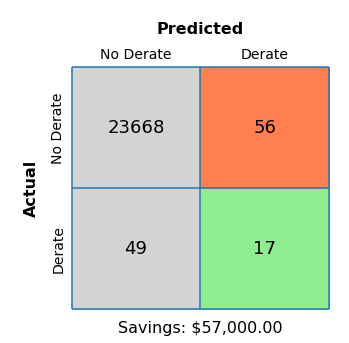

In [21]:
plot_confusion_matrix(y_test, [p[1] > 0.4 for p in y_test_prob], labels = ['No Derate', 'Derate'], metric = 'savings')

In [22]:
precision_score(y_test, [p[1] > 0.4 for p in y_test_prob])

0.2328767123287671